In [2]:
%%time
import os
import re.
os.chdir("/Users/iakubovskii/AppBooster/Base/AB_testing/")
from collections import Counter
from random import choices
from typing import List, Dict
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
# pd.options.plotting.backend = "plotly"

def gener_random_revenue(revenue_values: List):
    """
    :param revenue_values: historical revenue values
    :return: random value according to historical distribution
    """
    revenue_counter = Counter(revenue_values)
    values = list(revenue_counter.keys())
    probs = list(map(lambda x: x / len(revenue_values), list(revenue_counter.values())))
    return choices(values, probs)
import json
with open('revenue_dict_6.json') as f:
    revenue_dict_6 = json.load(f)
with open('revenue_dict_7.json') as f:
    revenue_dict_7 = json.load(f)
def get_bootstrap_upper_bound(l):
    bootstr_mean = bs.bootstrap(stat_func=bs_stats.mean, values = l, 
                                num_threads = 1, 
                                num_iterations=1e04)
    conf_int = re.findall(r"\(.*", str(bootstr_mean))[0]
    upper_conf = float(conf_int.strip(")").split(", ")[1])
    return(upper_conf)
print({key: sum(values) for key, values in revenue_dict_6.items()})
upper_bounds = list(map(lambda x: get_bootstrap_upper_bound(x), 
                 list(map(np.array, revenue_dict_6.values()))))
upper_bounds

all_values = [values for key, values in revenue_dict_6.items()]
revenue_all = np.array(sum(all_values, [])).astype(np.float32)
revenue_dict = {key: revenue_all for key in revenue_dict_6.keys()}

{'2': 993.3300000000002, '3': 1238.17, '4': 69.82, '5': 922.86, '1': 2148.58, '0': 2604.1600000000008}
CPU times: user 1.67 s, sys: 511 ms, total: 2.18 s
Wall time: 2.84 s


In [3]:
from numba import jit, prange, set_num_threads
@jit(nopython=True, parallel=True)
def bootstrap_jit_parallel(data, boots=10000, quantile_=0.95):
    """
    Create bootstrap datasets that represent the distribution of the mean.
    Returns a numpy array containing the bootstrap datasets 
    
    Keyword arguments:
    data -- numpy array of systems to boostrap
    boots -- number of bootstrap (default = 1000)
    """
        
    to_return = np.empty(boots)
                
    for b in prange(boots):
        
        total=0.0
        
        for s in range(data.shape[0]):
        
            total += data[np.random.randint(0, data.shape[0])]

        to_return[b] = total / data.shape[0]
    quantile_95 = np.quantile(to_return, quantile_)
    return quantile_95
@jit(nopython=True)
def bootstrap_jit(data, boots=10000):
    """
    Create bootstrap datasets that represent the distribution of the mean.
    Returns a numpy array containing the bootstrap datasets 
    
    Keyword arguments:
    data -- numpy array of systems to boostrap
    boots -- number of bootstrap (default = 1000)
    """
        
    to_return = np.empty(boots)
    
                
    for b in range(boots):
        
        total=0.0
        
        for s in range(data.shape[0]):

            total += data[np.random.randint(0, data.shape[0])]

        to_return[b] = total / data.shape[0]
    quantile_95 = np.quantile(to_return, 0.95)
    return quantile_95

<Figure size 1280x720 with 0 Axes>

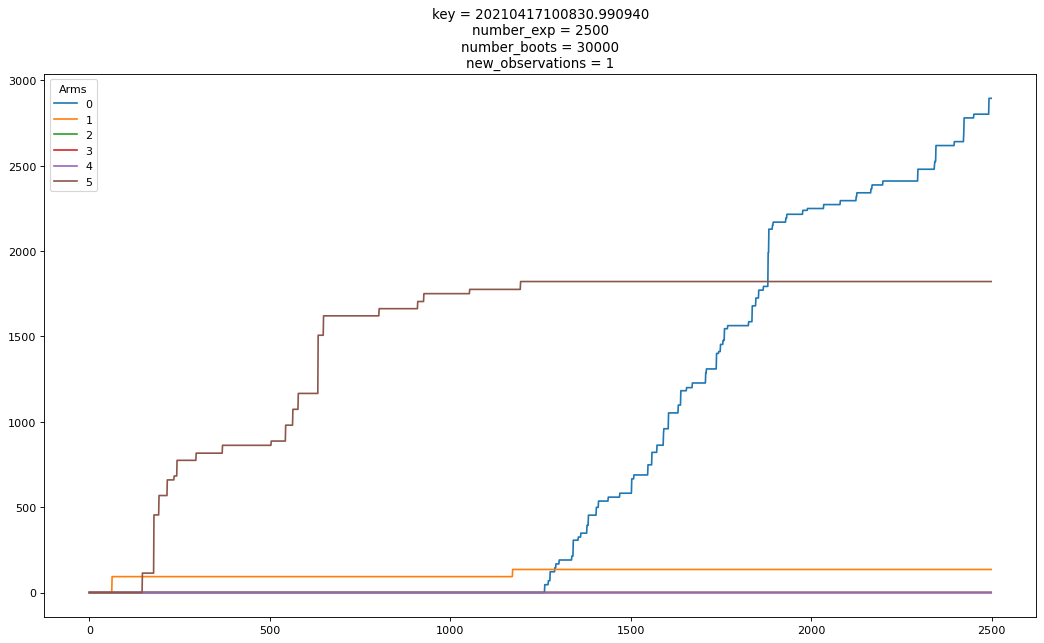

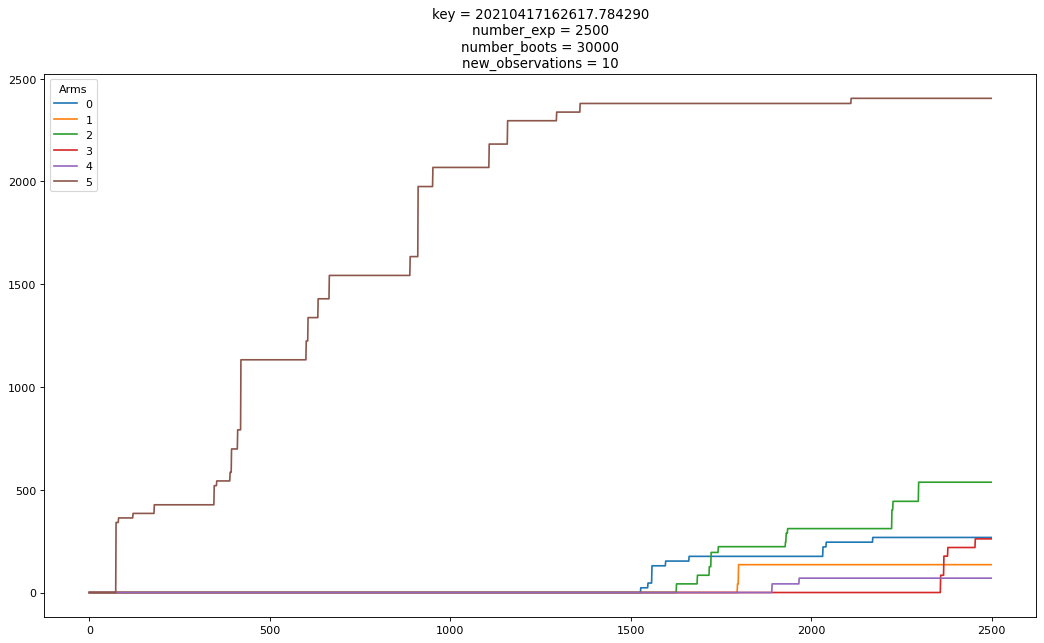

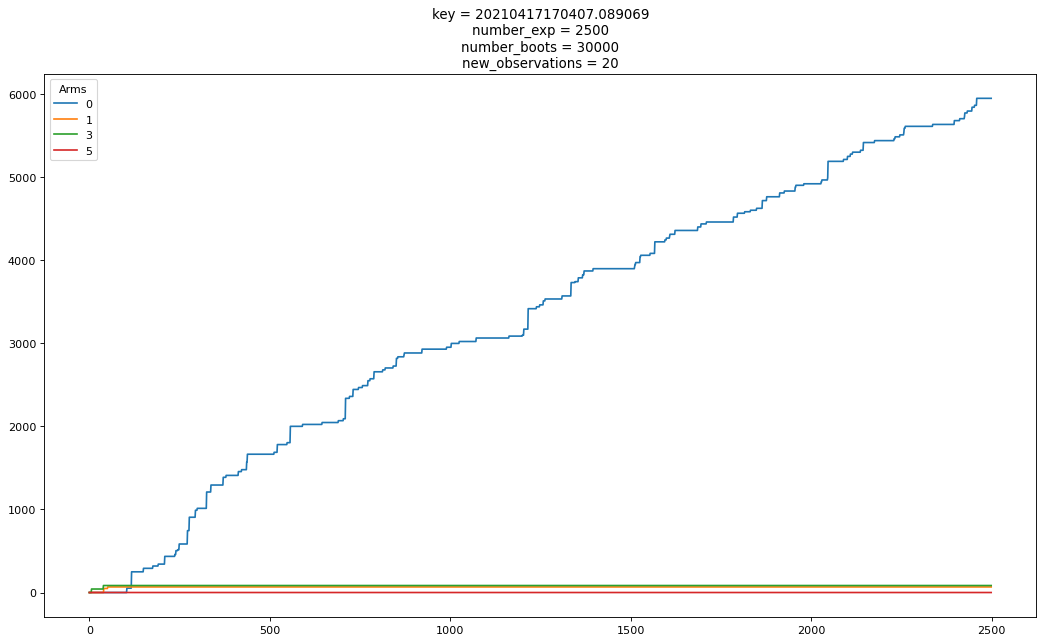

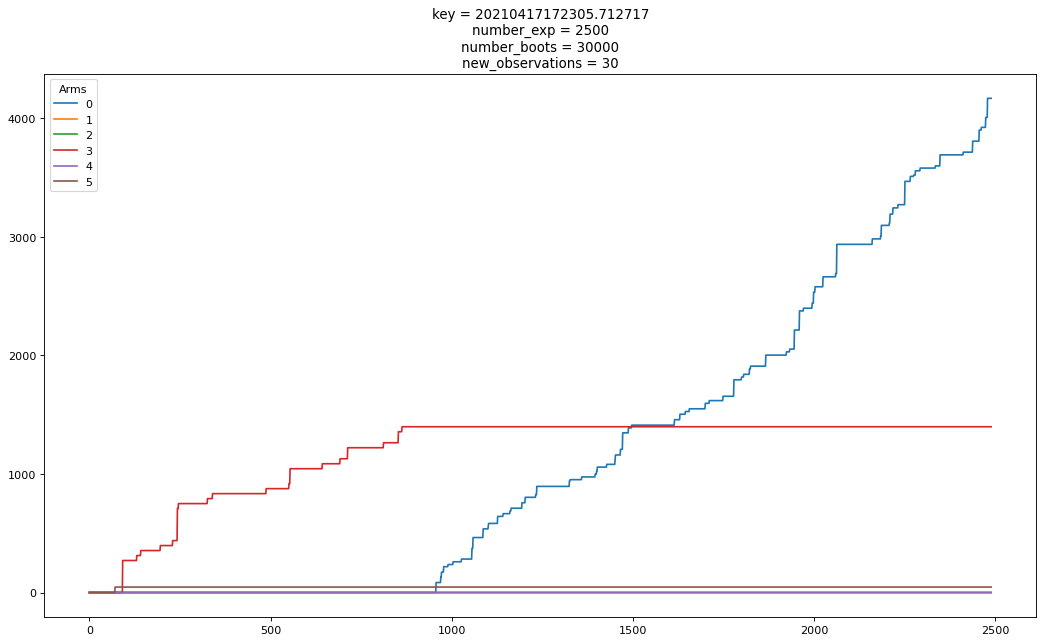

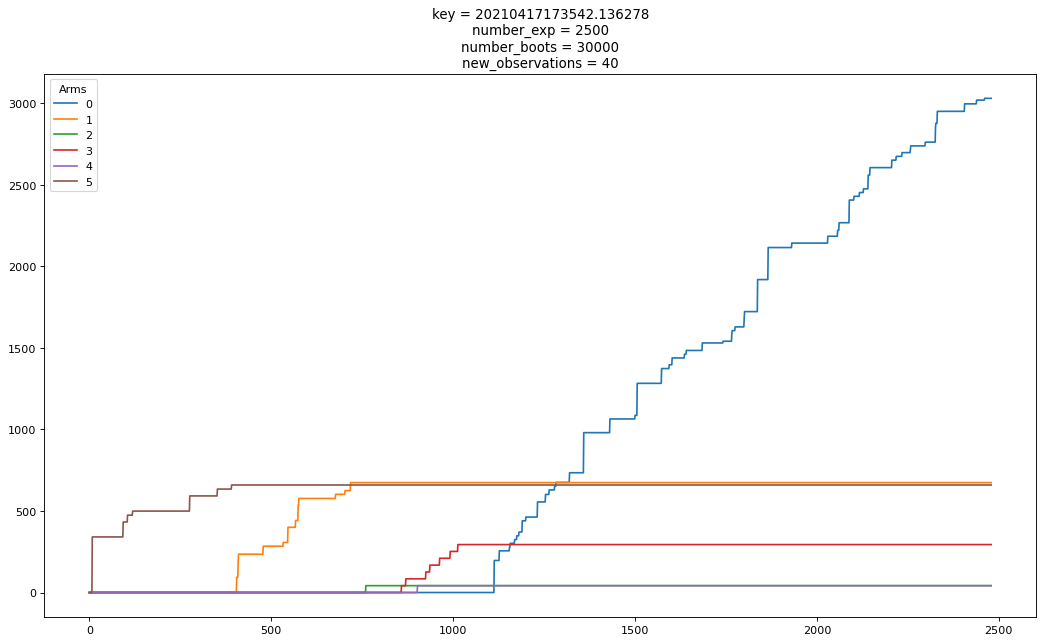

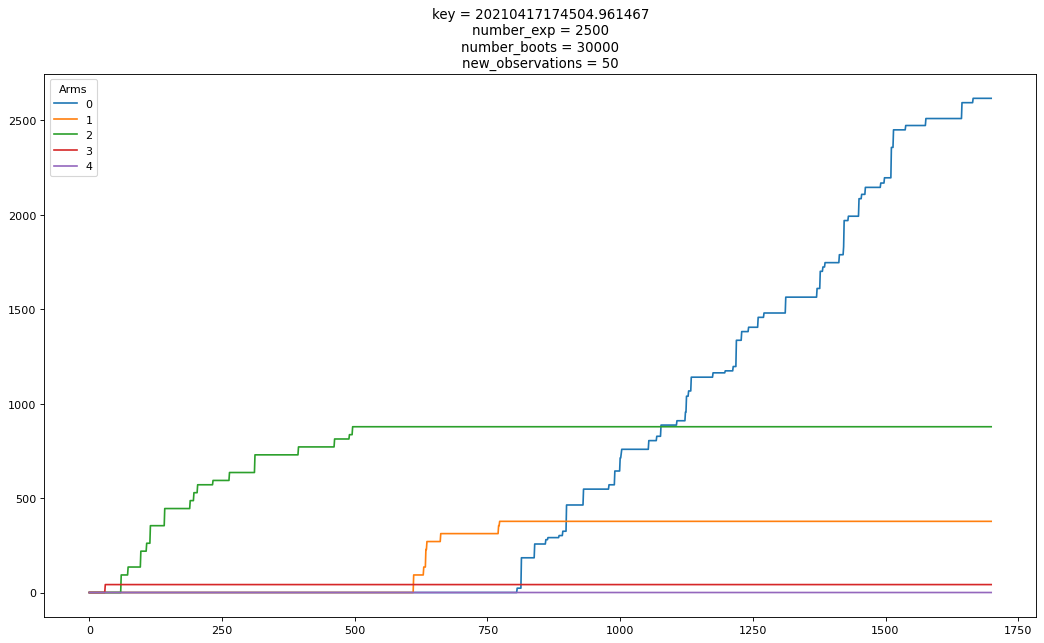

In [67]:
def get_df(dict_, key):
    data = pd.DataFrame(dict_[key]['revenue_experiment']).explode("revenues")
    data['revenues'] = pd.to_numeric(data['revenues'], errors = 'coerce')
    data['index'] = np.arange(data.shape[0])
    pivot_df = pd.pivot_table(data, index = 'index', columns = 'actions',
                             values = 'revenues').fillna(0).cumsum()
    pivot_df['key'] = key
#     pivot_df['info'] = dict_[key]['info']
    return pivot_df 
file_name = 'rev_hist_dict_66'
with open("Experiments/" + file_name + ".json") as f:
    dict_ = json.load(f)
from matplotlib.pyplot import figure
figure(figsize=(16, 9), dpi=80)
import matplotlib.pyplot as plt
def different_options_fig(dict_, key):
    df_ = get_df(dict_, key)
    fig = plt.figure(figsize=(16,9), dpi=80)
    ax = plt.plot(df_.drop("key", axis=1));
    plt.legend(df_.drop("key", axis=1).columns, title = "Arms");
    plt.title('key = ' + key + '\n' + 
                           'number_exp = ' + str(dict_[key]['info']['number_exp']) + '\n' +  
                           "number_boots = " + str(dict_[key]['info']['number_boots']) + '\n' +  
                           'new_observations = ' + str(dict_[key]['info']['new_observations']));
#     ax = df.drop("key", axis=1).plot(title = 
#                            'key = ' + key + '\n' + 
#                            'number_exp = ' + str(dict_[key]['info']['number_exp']) + '\n' +  
#                            "number_boots = " + str(dict_[key]['info']['number_boots']) + '\n' +  
#                            'new_observations = ' + str(dict_[key]['info']['new_observations']));
    return fig
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages(file_name + '.pdf') 
for key in tqdm(dict_.keys()): ## will open an empty extra figure :(
    fig = different_options_fig(dict_, key)
    pp.savefig(fig)
pp.close()

In [61]:
dict_.keys()

dict_keys(['20210417100553.684353', '20210417122950.289484', '20210417124422.752991', '20210417125139.745171', '20210417125631.230588', '20210417130012.551100', '20210417130310.031737', '20210417130536.882405', '20210417130745.776524', '20210417130937.741841', '20210417131115.286996', '20210417131249.108329', '20210417161124.899296', '20210417162933.972850', '20210417163834.735234', '20210417164435.586335', '20210417164907.276096', '20210417165245.962338', '20210417165549.514076', '20210417165826.714497', '20210417170047.100909', '20210417170254.025901', '20210417170446.977802'])

In [63]:
dict(zip(dict_['20210417100553.684353']['revenue_hist'].keys(),
    list(map(np.mean, dict_['20210417100553.684353']['revenue_hist'].values()))))

{'2': 1.4190428571428573,
 '3': 1.746361071932299,
 '4': 0.5630645161290322,
 '5': 1.2907132867132867,
 '1': 1.662987616099071,
 '0': 2.246902502157032}

In [64]:
dict(zip(dict_['20210417100553.684353']['revenue_hist'].keys(),
    list(map(np.sum, dict_['20210417100553.684353']['revenue_hist'].values()))))

{'2': 993.33,
 '3': 1238.17,
 '4': 69.82,
 '5': 922.86,
 '1': 2148.58,
 '0': 2604.16}

In [65]:
dict(zip(dict_['20210417100553.684353']['revenue_hist'].keys(),
    list(map(np.shape, dict_['20210417100553.684353']['revenue_hist'].values()))))

{'2': (700,),
 '3': (709,),
 '4': (124,),
 '5': (715,),
 '1': (1292,),
 '0': (1159,)}

In [66]:
dict(zip(dict_['20210417100553.684353']['revenue_hist'].keys(),
    list(map(np.count_nonzero, dict_['20210417100553.684353']['revenue_hist'].values()))))

{'2': 19, '3': 19, '4': 2, '5': 12, '1': 43, '0': 54}

In [ ]:
from collections import defaultdict
mydict = defaultdict(lambda: "Not Present Yet" )
mydict['cat'] = {"info": [],
                'value':[],
                "kek": []}